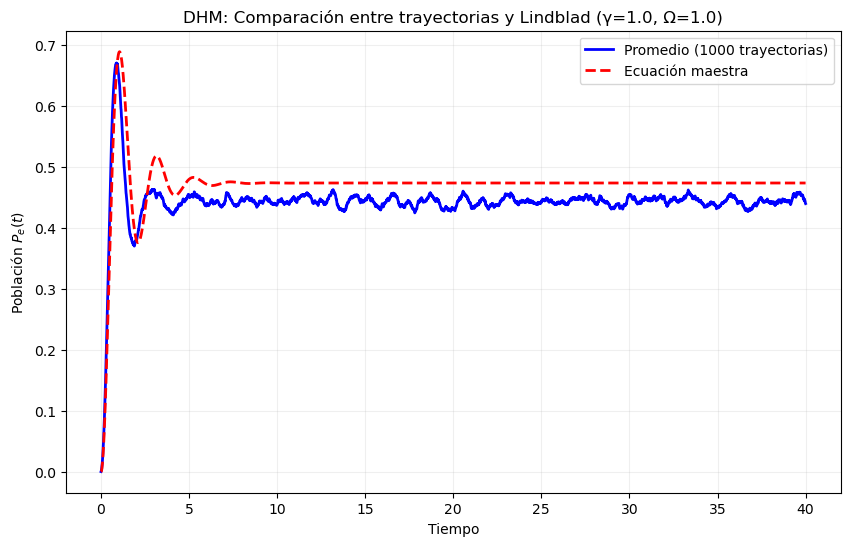

In [13]:
#Disipacion!
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Parámetros
gamma = 1          # Tasa de detección
phi = 0.0            # Fase del oscilador local (homodina)
t_max = 40          # Tiempo de simulación
dt = 0.01           # Paso de tiempo (reducido para precisión)
Omega = 3          # Frecuencia de Rabi
steps = int(t_max / dt)
Delta = 0.0          # Desintonía
num_traj = 1000     # Número de trayectorias

# Operadores cuánticos
sm = qt.destroy(2)   # σ-
sp = sm.dag()        # σ+
sigma_x = qt.sigmax()# Operador σ_x (para ϕ=0, σ_ϕ = σ_x)
Pe = sp * sm         # Proyector |e⟩⟨e|

# Hamiltoniano del sistema (Rabi)

H_sys= (Delta)*sp*sm + Omega*0.5*(sp + sm)

# Función para una trayectoria estocástica
def simulate_trajectory():
    dW = np.sqrt(dt) * np.random.randn(steps)  # Ruido de Wiener
    psi_t = (qt.basis(2, 0) ).unit()  # Estado inicial |g⟩ + |e⟩
    pop_exc = []
    
    for i in range(steps):
        # Valor esperado de σ_x (para ϕ=0)
        sigma_x_expect = qt.expect(sigma_x, psi_t)
        
        # Término de retroalimentación (η_W = dW/dt)
        H_feedback = 1j * (2 * np.sqrt(gamma) * sigma_x_expect + dW[i] / dt) * np.sqrt(gamma) * sm
        H_total = H_sys + H_feedback
        
        # Evolución del estado
        dpsi = (-1j * H_total * psi_t) * dt
        psi_t = (psi_t + dpsi).unit()
        pop_exc.append(qt.expect(Pe, psi_t))
    
    return pop_exc

# Simulación de múltiples trayectorias
trajectories = np.zeros((num_traj, steps))
for k in range(num_traj):
    trajectories[k, :] = simulate_trajectory()
    print(f"Progreso: {k+1}/{num_traj}", end="\r")

# Promedio de trayectorias
average_pop = np.mean(trajectories, axis=0)

HsysME=(Delta)*sp*sm + Omega*0.5*(sp + sm)
# Ecuación maestra (Lindblad)
c_ops = [np.sqrt(gamma) * sm]  # Operador de colapso
rho0 = qt.ket2dm((qt.basis(2, 0) ).unit())  # Estado inicial
times = np.linspace(0, t_max, steps)
result = qt.mesolve(HsysME, rho0, times, c_ops, [Pe])
lindblad_pop = result.expect[0]

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(times, average_pop, 'b-', label=f"Promedio ({num_traj} trayectorias)", linewidth=2)
plt.plot(times, lindblad_pop, 'r--', label="Ecuación maestra", linewidth=2)
plt.xlabel("Tiempo")
plt.ylabel("Población $P_e(t)$")
plt.title("DHM: Comparación entre trayectorias y Lindblad (γ=1.0, Ω=1.0)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()